In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from functools import partial

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
url = 'root://eosuser.cern.ch/'

In [3]:
def get_local_alt(f):
    to_local = lambda f : f.replace('/eos/user/e/ekoenig/','/store/user/ekoenig/')
    alt_pattern = to_local(f)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    if any(alt_glob):
        return alt_glob
    
    remote_glob = fc.fs.cernbox.glob(f)
    if any(remote_glob):
        alt_glob = [ to_local(f) for f in remote_glob ]
        remote_glob = [ fc.fs.cernbox.fullpath(f) for f in remote_glob ]
        fc.fs.eos.batch_copy_to(remote_glob, alt_glob)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    return alt_glob

In [4]:
treekwargs = dict(
            use_gen=False,
            treename='Events',
            normalization=None,
        )

f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/{pairing}_sig_2018_0L/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(pairing='mindiag')

signal = ObjIter([Tree( get_local_alt(f_sig), **treekwargs)])
signal.apply(lambda t : t.reweight(t.genWeight * t.xsecWeight / 1000))

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


[None]

In [5]:
tree = signal[0]

In [6]:
signal.apply(fourb.nanohh4bUtils.match_ak4_gen)

[None]

100%|██████████| 2/2 [00:00<00:00, 24.09it/s]


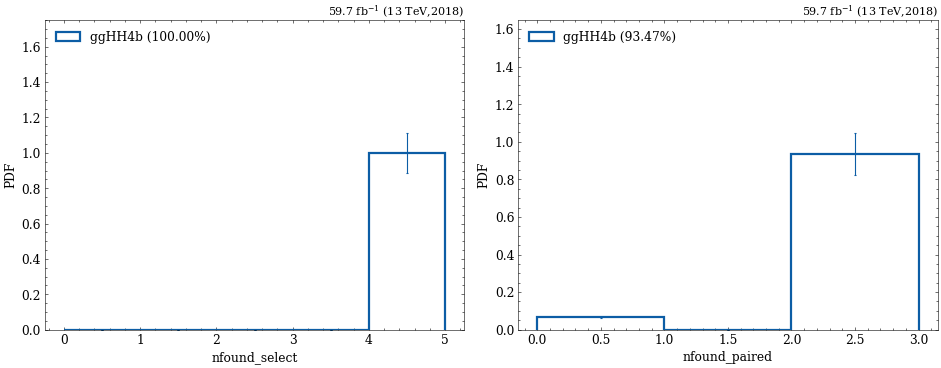

In [7]:
study.quick(
    signal,
    masks=lambda t : t.nfound_select==4,
    varlist=['nfound_select', 'nfound_paired'],
    h_label_stat=lambda h : f'{h.histo[-1]:0.2%}',
    legend=True,
    efficiency=True,
)